# Hyperparameter optimization

Grand et al data

Hyperparameter optimization on a development set.

# Reading the data

## GloVE

In [1]:
import os
from scipy import stats
import numpy as np 
import pandas as pd
import zipfile
import math
import sklearn
import torch
import torch.optim as optim
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt

In [2]:
glove_path = "glove/glove.42B.300d.zip"
glove_file = "glove.42B.300d.txt"

feature_dim = 300

word_vectors = { }

with zipfile.ZipFile(glove_path) as azip:
    with azip.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode()
            vector = np.array(values[1:], dtype=np.float32)
            word_vectors[word] = vector

## Grand features

In [3]:
grandratings_dir = "Grand_etal_csv/"
grandfeatures_path = "/Users/kee252/Data/grand_directions_in_space/features.xlsx"

grandfeatures_df = pd.read_excel(grandfeatures_path)

/Users/kee252/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Function for reading a specific Grand dataset

In [4]:
# reading in Grand data
def read_grand_data(filename, grandratings_dir, grandfeatures_df):
    # extract category and feature
    grandcategory, grandfeature = filename[:-4].split("_")
        
    # read human ratings, make gold column
    df = pd.read_csv(grandratings_dir + filename)
    nspeakers = len(df.columns) -1
    df["Average"] = [row.iloc[1:26].sum() / nspeakers for _, row in df.iterrows()]
    # z-scores of average ratings
    df["Gold"] = (df["Average"] - df["Average"].mean()) / df["Average"].std()
        
    # obtain seed words from excel file
    relevant_row = grandfeatures_df[grandfeatures_df.Dimension == grandfeature]
    seedwords = relevant_row.iloc[:, 1:].values.flatten().tolist()
    pos_seedwords = seedwords[:3]
    neg_seedwords = seedwords[3:]
    
    return (grandcategory, grandfeature, pos_seedwords, neg_seedwords, df)

# Function for running crossvalidation

In [12]:
import eval_dim
import compute_dim
import statistics

def crossvalidation(filenames, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = 123, verbose = False):
    
    all_evals = [ ]
    
    for filename in filenames:
            grandcategory, grandfeature, pos_seedwords, neg_seedwords, df = read_grand_data(filename, 
                                                                                            grandratings_dir, 
                                                                                            grandfeatures_df)


            # storage for word vectors and gold values for this dataset
            all_thisdata_vectors = []
            all_thisdata_gold = []

            # collect word vectors and gold ratings
            for row in df.itertuples():
                # row.Row is the word. look it up in word_vectors
                all_thisdata_vectors.append( word_vectors[ row.Row ])
                # gold rating: use z-scored average
                all_thisdata_gold.append( row.Gold)

            # crossvalidation setup: give indices to datapoints
            fold = np.random.randint(method["numfolds"], size = len(all_thisdata_gold))

            # store the evaluation results from the different test folds
            evals = [ ]

            # iterate over folds, evaluate for each of them
            for testfold in range(method["numfolds"]):
                # compute training and test data for this fold
                test_indices =  [i for i in range(len(all_thisdata_gold)) if fold[i] == testfold]
                train_indices = [i for i in range(len(all_thisdata_gold)) if fold[i] != testfold]

                gold_test =  [ell["Gold"] for _, ell in df.iloc[ test_indices ].iterrows()]
                gold_train = [ ell["Gold"] for _, ell in df.iloc[ train_indices ].iterrows()]
                words_test =  [ell["Row"] for _, ell in df.iloc[ test_indices].iterrows()]
                words_train = [ell["Row"] for _, ell in df.iloc[ train_indices].iterrows()]
                vec_test =  [word_vectors[ w ] for w in words_test]
                vec_train = [word_vectors[ w ] for w in words_train ]


                # compute seed-based dimension, and its predictions
                if method["method"] == "seedbased":
                    dimension = compute_dim.dimension_seedbased(pos_seedwords, neg_seedwords, word_vectors)
                    df["Pred"] = compute_dim.predict_coord_fromtrain(vec_train, gold_train, dimension, all_thisdata_vectors)

                elif method["method"] == "fitted":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings(vec_train, gold_train, 
                                                                                       method["feature_dim"],
                                                                                       random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seedwords":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seedwords(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "fitted_seeddims":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_seeddims(vec_train, gold_train, 
                                                                    method["feature_dim"], 
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                elif method["method"] == "combined":
                    dimension, weight, bias = compute_dim.dimension_fitted_fromratings_combined(vec_train, gold_train,
                                                                    method["feature_dim"],
                                                                    pos_seedwords, neg_seedwords, word_vectors,
                                                                    offset = method["offset"], jitter = method["jitter"],
                                                                    do_average = method["do_average"], 
                                                                    alpha = method["alpha"],
                                                                    random_seed = random_seed)
                    df["Pred"] = compute_dim.predict_coord_fromline(all_thisdata_vectors, dimension, weight, bias)

                else:
                    raise Exception("shouldn't be here")

                # order consistency pairwise: test values tested for their ordering wrt. all values, training and test
                # MSE: evaluate on test only
                e = { "ocp" : eval_dim.pairwise_order_consistency_wrt(df["Gold"], df["Pred"], test_indices),
                      "mse" : eval_dim.mean_squared_error(gold_test, [p for i, p in enumerate(df["Pred"]) if i in test_indices]),
                      "feature" : grandfeature,
                      "category" : grandcategory}

                all_evals.append(e)

    if verbose:
        ocps = [e["ocp"] for e in all_evals if e["ocp"] is not None]
        mses = [e["mse"] for e in all_evals if e["mse"] is not None]

        print("\n\nOverall", method["method"], 
              f"OC_p {statistics.mean(ocps):.3f} ({statistics.stdev(ocps):.2f})", 
              f"MSE mean {statistics.mean(mses):.3f} ({statistics.stdev(mses):.2f}) median {statistics.median(mses):.3f}")
        
    return all_evals


# Function for aggregating crossvalidation results

First aggregate by dataset, then aggregate over datasets.

In [9]:
from collections import defaultdict
import statistics

def ocp_mse_crossvalidation_readoff(evals):
    bydataset_eval = defaultdict(list)
    
    for e in evals:
        bydataset_eval[ (e["category"], e["feature"])].append(e)
        
    ocp_mean = [ ]
    ocp_stdev = [ ]
    mse_mean = [ ]
    mse_stdev = [ ]
    mse_med = [ ]
    for ekey, es in bydataset_eval.items():
        os = [e["ocp"] for e in es if e["ocp"] is not None]
        ms = [e["mse"] for m in es if e["mse"] is not None]
        if len(os) > 0:
            ocp_mean.append( statistics.mean(os) )
            ocp_stdev.append( statistics.stdev(os))
        if len(ms) > 0:
            mse_mean.append( statistics.mean(ms) )
            mse_stdev.append( statistics.stdev(ms))
            mse_med.append( statistics.median(ms))
        
        
    return (statistics.mean(ocp_mean), statistics.mean(ocp_stdev), 
            statistics.mean(mse_mean), statistics.mean(mse_stdev), statistics.mean(mse_med))

# Making a development set

In [7]:
filenames = [f for f in os.listdir(grandratings_dir) if f.endswith("csv")]

import random
random.seed(789)
devset = random.sample(filenames, 6)
[ filename[:-4].split("_") for filename in devset]

[['cities', 'danger'],
 ['states', 'political'],
 ['animals', 'wetness'],
 ['cities', 'intelligence'],
 ['animals', 'weight'],
 ['names', 'age']]

# Determining hyperparameters

## Fitted dimensions with seeds as words: offset, jitter

First experiments looked like there was a lot of variance in result with different random seeds. To check into this, we run the hyperparameter tests 10 times with different random seeds. We then look at mean and standard deviation of the two measures we focus on: mean OC_p and median MSE.

In [11]:
jitter_vals = [True, False]
offset_vals= np.linspace(0.1, 2, num=20)

results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(5)]

for randval in randoms:
    for jval in jitter_vals:
        for oval in offset_vals:

            method = { "method": "fitted_seedwords",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "offset" : oval,
                      "jitter" : jval}


            evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

            print(oval, jval, ocp_mean, mse_med)

            results.append( {"j": jval, "offset": oval, "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                             "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



0.1 True 0.6076658375637968 12.52232380225612
0.2 True 0.601299314819723 42.24113149474583
0.3 True 0.6067431871250671 16.642370782076796
0.4 True 0.618646744277451 16.745095141266383
0.5 True 0.5970688819243241 7.161754381740096
0.6 True 0.5983668265470986 3.891937282026014
0.7 True 0.6098629336294402 31.19323115458773
0.7999999999999999 True 0.5908231372146029 14.68052422239514
0.8999999999999999 True 0.6076311443658382 11.369018543309346
0.9999999999999999 True 0.6016400995222524 12.300178627145563
1.0999999999999999 True 0.6247930397953589 12.196427874025922
1.2 True 0.6185982388108239 22.501514670683555
1.3 True 0.6218040774418325 12.318802077178253
1.4 True 0.6141541067901612 15.480987521543684
1.5 True 0.594007172595608 14.625181830223378
1.5999999999999999 True 0.5871437160722874 23.891124322436113
1.7 True 0.6170994840382595 13.857058069876974
1.8 True 0.6115720472523194 13.402739147348742
1.9 True 0.582824304695053 19.03056393395481
2.0 True 0.6014064148247822 12.135184950240

In [13]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["offset"]), r["j"])].append(r)
    


In [14]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"j": rs[0]["j"], "offset": rs[0]["offset"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

We plot mean OC_P values, with standard deviation. The differences in result are minimal compared to the error bars: It basically doesn't matter which value we pick. 

<AxesSubplot: xlabel='offset'>

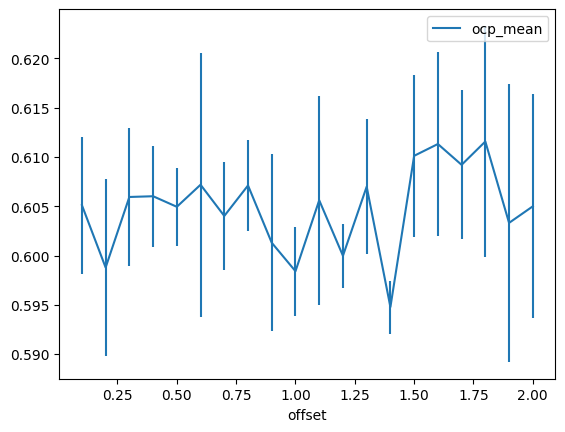

In [20]:
%matplotlib inline
df = pd.DataFrame(rnew)
df[df.j == False].plot(y = "ocp_mean",x = "offset", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='offset'>

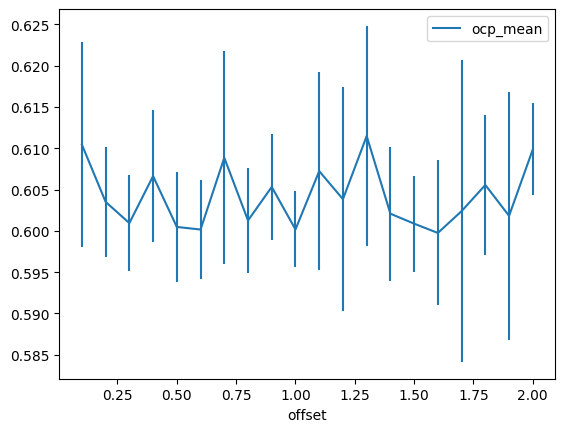

In [21]:
df[df.j == True].plot(y = "ocp_mean", x = "offset", yerr = "ocp_mean_sd")

We plot mean values of median MSE, with standard deviation. Here the difference in results is clearly dwarfed by the error bars: It does not matter at all which values we pick. 

<AxesSubplot: xlabel='offset'>

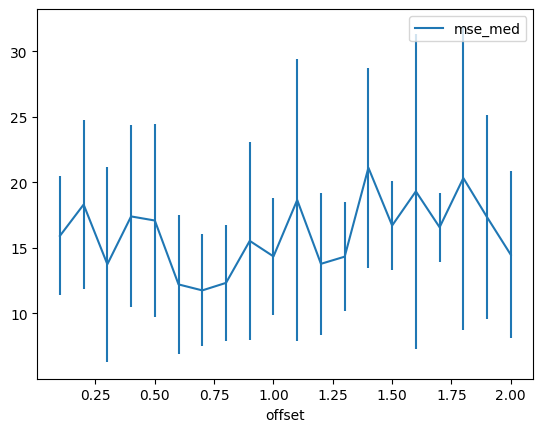

In [22]:
df[df.j == False].plot(y = "mse_med", x = "offset", yerr = "mse_med_sd")

<AxesSubplot: xlabel='offset'>

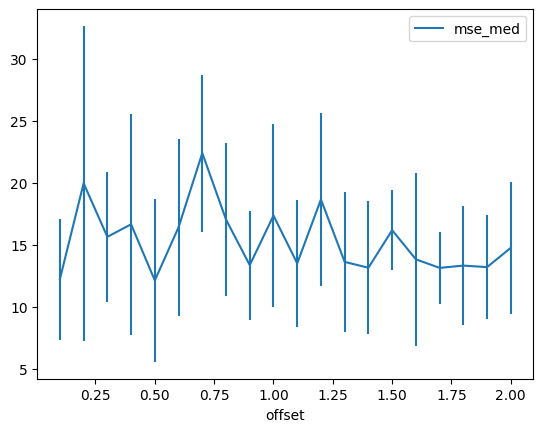

In [23]:
df[df.j == True].plot(y = "mse_med", x = "offset", yerr = "mse_med_sd")

### Parameters for seeds as words

Because we need to pick some value, we pick the one with second best OC_P, which is very close to the best OC_P but with much lower MSE. We use an **offset of 1.3, with jitter.** 

In [19]:
df.sort_values(by = "ocp_mean", ascending = False).head(10)

,j,offset,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
37,False,1.8,0.611562,0.099605,20.334354,20.334354,0.0,0.011721,11.613239
12,True,1.3,0.611475,0.103951,13.635649,13.635649,0.0,0.013330,5.634202
35,False,1.6,0.611307,0.093714,19.318911,19.318911,0.0,0.009371,11.999762
0,True,0.1,0.610436,0.099801,12.252196,12.252196,0.0,0.012369,4.874772
34,False,1.5,0.610111,0.104265,16.711059,16.711059,0.0,0.008192,3.416357
19,True,2.0,0.609855,0.096426,14.771072,14.771072,0.0,0.005569,5.309839
36,False,1.7,0.609195,0.096595,16.576972,16.576972,0.0,0.007541,2.623566
6,True,0.7,0.608849,0.092645,22.403263,22.403263,0.0,0.012887,6.329045
10,True,1.1,0.607227,0.110158,13.520561,13.520561,0.0,0.012021,5.104297
25,False,0.6,0.607179,0.101274,12.214182,12.214182,0.0,0.013381,5.275349


## Fitted dimensions with seeds as dimensions: alpha, averaging

We first run an exploration, with only one random seed.

In [24]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.25, num=10)

results = [ ]

randoms = [123]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

            print(avgval, alphaval, ocp_mean, mse_med)

            results.append( {"avg": avgval, "alpha": alphaval, "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                             "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True 0.001 0.6926200405792242 6.41404780424088
True 0.028666666666666667 0.6982251651152394 1.702038699862503
True 0.05633333333333333 0.681675985893673 2.2466651390709416
True 0.08399999999999999 0.6821645405488943 4.558043698493325
True 0.11166666666666666 0.6819853674120835 2.1771438200823736
True 0.13933333333333334 0.6743427691665168 4.973445882798935
True 0.16699999999999998 0.6734819740602054 6.175589888167013
True 0.19466666666666665 0.6580593584420116 3.3352628290058877
True 0.22233333333333333 0.6577247248845888 4.036494873248509
True 0.25 0.6341798302249756 4.856372585562327
False 0.001 0.6791896954141852 0.7648938017451957
False 0.028666666666666667 0.6714772566813383 2.5866402148035257
False 0.05633333333333333 0.661146220874112 3.6882400771435386
False 0.08399999999999999 0.6644315807248707 6.322266228969725
False 0.11166666666666666 0.6546584053386775 2.006933752510032
False 0.13933333333333334 0.6526020823469803 3.6945380175725893
False 0.16699999999999998 0.64599010958

<AxesSubplot: xlabel='alpha'>

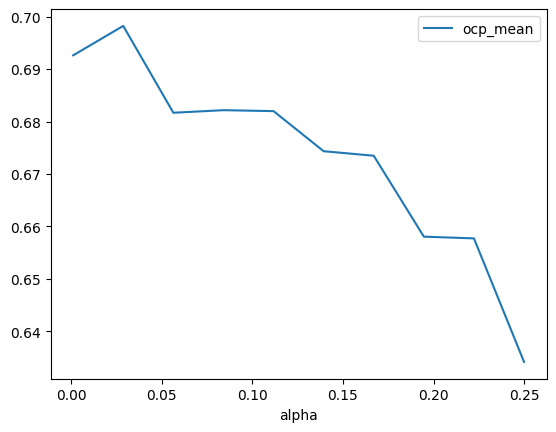

In [25]:
df = pd.DataFrame(results)
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean")

<AxesSubplot: xlabel='alpha'>

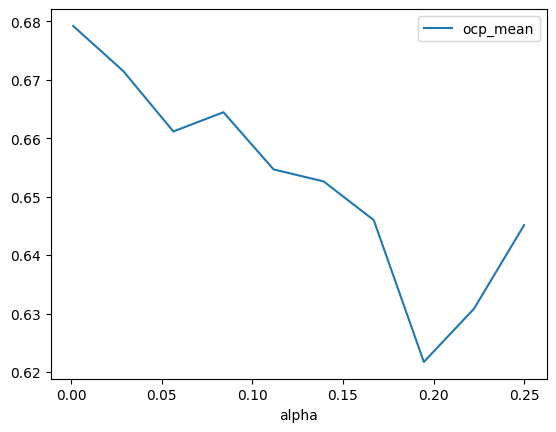

In [26]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "ocp_mean")

<AxesSubplot: xlabel='alpha'>

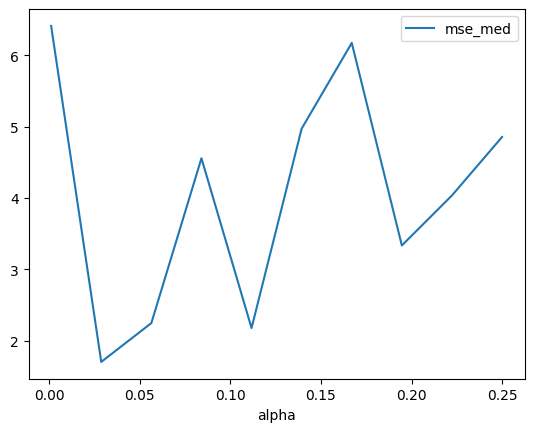

In [27]:
df[df.avg == True].sort_values(by = "alpha").plot(x = "alpha", y = "mse_med")

<AxesSubplot: xlabel='alpha'>

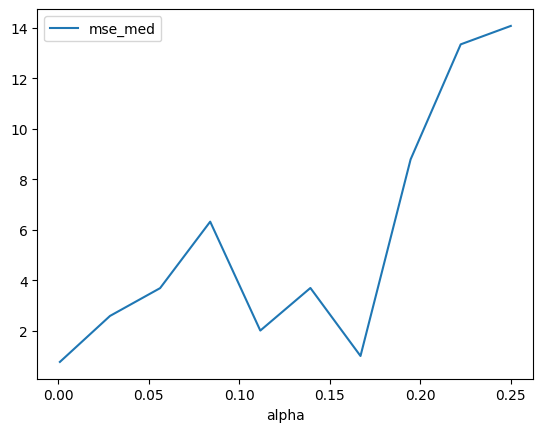

In [28]:
df[df.avg == False].sort_values(by = "alpha").plot(x = "alpha", y = "mse_med")

We see that overall the performance is best, in terms of both OC_P and MSE, for small values of alpha. We explore the low range of alpha in more detail, both with and without averaging. OC_P values take a steep dive from about 0.68 to about 0.62 when alpha rises from 0.01 to 0.25. 

This time we do re-run the analysis several times to obtain error bars.

In [29]:
average_vals = [True, False]
alpha_vals= np.linspace(0.001, 0.1, num=10)

results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(5)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:

            method = { "method": "fitted_seeddims",
                      "feature_dim" : feature_dim,
                      "numfolds" : 5,
                      "do_average" : avgval,
                      "alpha" : alphaval}


            evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
            ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

            print(avgval, alphaval, ocp_mean, mse_med)

            results.append( {"avg": avgval, "alpha": alphaval, "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                             "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True 0.001 0.6680148454468182 6.687963278409717
True 0.012 0.6947443483930806 2.5965980854991884
True 0.023000000000000003 0.6805180447507378 2.9486325016043446
True 0.034 0.6789966920834267 2.2648938934722134
True 0.045000000000000005 0.654617157461477 1.5903682118841593
True 0.05600000000000001 0.6777078237962592 2.519973872066623
True 0.067 0.6851497013602765 3.0450569307652744
True 0.07800000000000001 0.66531936695202 2.813508107888159
True 0.08900000000000001 0.6720961398767521 1.2064819205686246
True 0.1 0.6418373708679831 5.4494636623410635
False 0.001 0.6619681339069095 5.105579198592283
False 0.012 0.6879022978327245 0.8755051484668106
False 0.023000000000000003 0.6672199603747223 1.8020651567177295
False 0.034 0.668867966878171 3.2604827724339276
False 0.045000000000000005 0.6624488120256428 1.7562771132609118
False 0.05600000000000001 0.6379174604684809 0.6611660251208795
False 0.067 0.6540485739195223 2.7513730981542057
False 0.07800000000000001 0.6453382318628417 2.7420907

In [30]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["alpha"]), r["avg"])].append(r)
    


In [31]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"avg": rs[0]["avg"], "alpha": rs[0]["alpha"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

We again plot average OC_P mean and MSE median values, with error bars. 

<AxesSubplot: xlabel='alpha'>

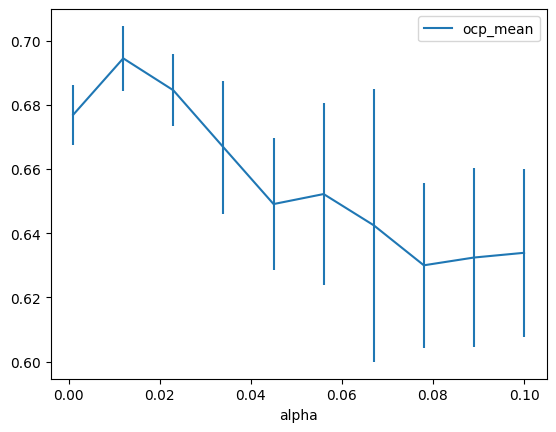

In [32]:
%matplotlib inline
df = pd.DataFrame(rnew)
df[df.avg == True].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='alpha'>

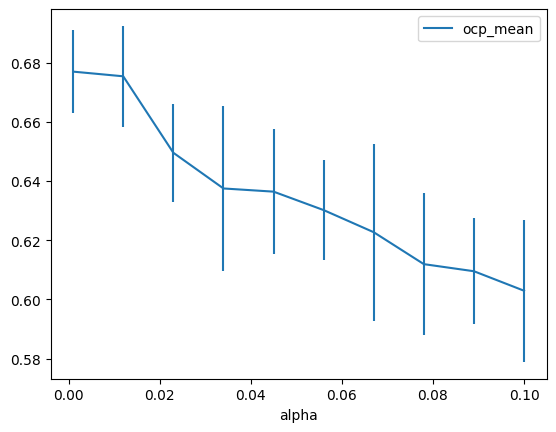

In [33]:
df[df.avg == False].plot(y = "ocp_mean", x = "alpha", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='alpha'>

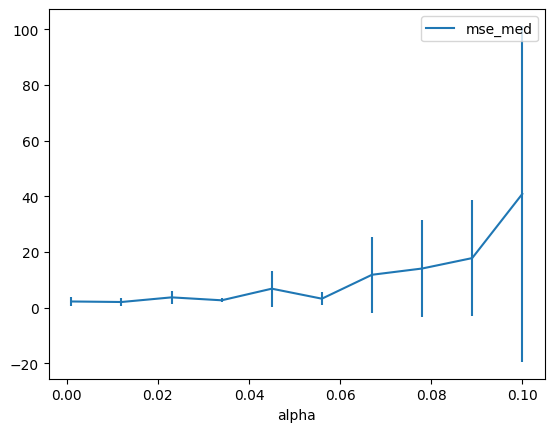

In [34]:
df[df.avg == False].plot(y = "mse_med", x = "alpha", yerr = "mse_med_sd")

<AxesSubplot: xlabel='alpha'>

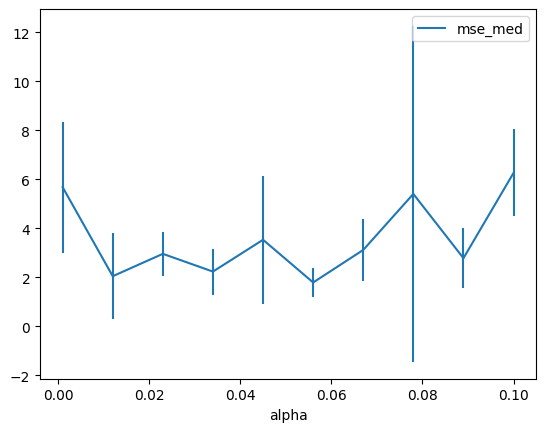

In [35]:
df[df.avg == True].plot(y = "mse_med", x = "alpha", yerr = "mse_med_sd")

Here the picture is quite clear: The almost-lowests value for alpha work best, both in terms of OC_P and MSE. Averaging over the seeds seems to lead to slightly higher OC_P values. With MSE it is hard to see because of scaling issues. 

We again look at the numbers.

In [36]:
df[df.avg == True].sort_values(by = 'ocp_mean', ascending = False).head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
1,True,0.012,0.694473,0.073453,2.040781,2.040781,0.0,0.010096,1.756349
2,True,0.023,0.684522,0.070060,2.954136,2.954136,0.0,0.011212,0.910079
0,True,0.001,0.676878,0.068377,5.674034,5.674034,0.0,0.009239,2.678072


In [37]:
df[df.avg == False].sort_values(by = 'ocp_mean', ascending = False).head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
10,False,0.001,0.676935,0.063861,2.217541,2.217541,0.0,0.014044,1.631900
11,False,0.012,0.675357,0.070930,2.030489,2.030489,0.0,0.017017,1.592064
12,False,0.023,0.649530,0.072172,3.696056,3.696056,0.0,0.016493,2.215731


In [38]:
df[df.avg == False].sort_values(by = 'mse_med').head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
11,False,0.012,0.675357,0.070930,2.030489,2.030489,0.0,0.017017,1.592064
10,False,0.001,0.676935,0.063861,2.217541,2.217541,0.0,0.014044,1.631900
13,False,0.034,0.637468,0.091487,2.642405,2.642405,0.0,0.027984,0.709214


In [39]:
df[df.avg == True].sort_values(by = 'mse_med').head(3)

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
5,True,0.056,0.652209,0.082244,1.785671,1.785671,0.0,0.028398,0.594513
1,True,0.012,0.694473,0.073453,2.040781,2.040781,0.0,0.010096,1.756349
3,True,0.034,0.666768,0.074641,2.229498,2.229498,0.0,0.020711,0.939561


We focus on OC_P because it is more stable, and go with **alpha = 0.01, with averaging over seeds.** 

# Combined model: seeds as words and dimensions

We fix jitter to be true, and averaging to be true, in order not to have too many conditions. We also fix offset to being 1.3, as before, as offset never makes much of a difference. We test different alpha values, with 3 random conditions. 

In [43]:
average_vals = [True]
alpha_vals= np.linspace(0.001, 0.1, num=10)
jitter_vals = [True]
offset_vals= [ 1.3 ]


results = [ ]

random.seed(5)
randoms = [random.randrange(0,100) for _ in range(3)]

for randval in randoms:
    for avgval in average_vals:
        for alphaval in alpha_vals:
            for oval in offset_vals:
                for jval in jitter_vals:

                    method = { "method": "combined",
                              "feature_dim" : feature_dim,
                              "numfolds" : 5,
                              "do_average" : avgval,
                              "alpha" : alphaval,
                              "offset" : oval,
                              "jitter" : jval}


                    evals = crossvalidation(devset, method, word_vectors, grandratings_dir, grandfeatures_df, random_seed = randval)
                    ocp_mean, ocp_stdev, mse_mean, mse_stdev, mse_med = ocp_mse_crossvalidation_readoff(evals)

                    print(avgval, jval, alphaval, oval, ocp_mean, mse_med)

                    results.append( {"avg": avgval, "alpha": alphaval, "j" : jval, "offset" : oval,
                                     "ocp_mean" : ocp_mean, "ocp_stdev" : ocp_stdev, 
                                     "mse_mean" : mse_mean, "mse_stdev" : mse_stdev, "mse_med" : mse_med})



True True 0.001 1.3 0.6927708050327098 0.9130273114448266
True True 0.012 1.3 0.6998922630435236 1.8567384761048333
True True 0.023000000000000003 1.3 0.7553518967804682 0.7805226242179397
True True 0.034 1.3 0.8070852339899959 0.21770945153601032
True True 0.045000000000000005 1.3 0.82184294163886 0.27380211072475685
True True 0.05600000000000001 1.3 0.8297332051923889 0.363172177577947
True True 0.067 1.3 0.8207111337893651 0.3288592853966362
True True 0.07800000000000001 1.3 0.8251579032908838 0.10485537320241124
True True 0.08900000000000001 1.3 0.8196233677108754 0.31658794955014913
True True 0.1 1.3 0.8087786677922733 0.37352164950871397
True True 0.001 1.3 0.7177713853177675 1.2908873026069485
True True 0.012 1.3 0.7265697926412211 1.9876017366198597
True True 0.023000000000000003 1.3 0.7886488549243651 1.0521825140539631
True True 0.034 1.3 0.8150864967106464 0.7046170848007816
True True 0.045000000000000005 1.3 0.8332244538026851 0.6009242382859242
True True 0.0560000000000000

## Plotting the results

We get 5 bars per alpha value, one for each offset value. Overall impression: there is a sweet spot for alpha around 0.0625 both in terms of OC_P and MSE, which holds across all values of jitter and averaging. There doesn't seem to be any consistent effect of offsets. We explore that area of alpha in more detail, with several random settings. 

In [44]:
# aggregating over multiple random seeds
results_all = defaultdict(list)
for r in results:
    results_all[(str(r["alpha"]), r["avg"])].append(r)
    


In [45]:
rnew = [ ]
for rs in results_all.values():
    rnew.append({"avg": rs[0]["avg"], "alpha": rs[0]["alpha"],
                 "ocp_mean":  statistics.mean([r["ocp_mean"] for r in rs]),
                 "ocp_stdev": statistics.mean([r["ocp_stdev"] for r in rs]),
                 "mse_mean":  statistics.mean([r["mse_mean"] for r in rs]),
                 "mse_med":   statistics.mean([r["mse_med"] for r in rs]),
                 "mse_stdev": statistics.mean([r["mse_stdev"] for r in rs]),
                 "ocp_mean_sd" : statistics.stdev([r["ocp_mean"] for r in rs]),
                 "mse_med_sd" : statistics.stdev([r["mse_med"] for r in rs])})

In [46]:
df = pd.DataFrame(rnew)

<AxesSubplot: xlabel='alpha'>

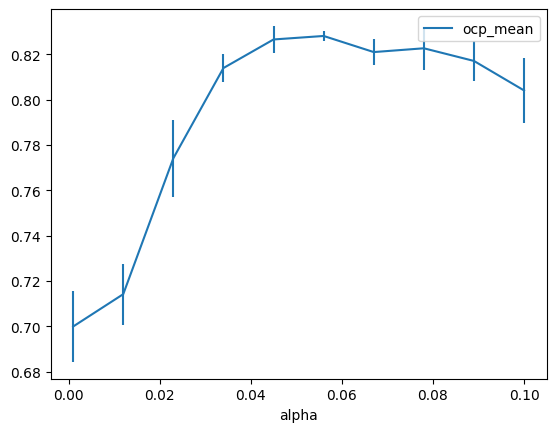

In [47]:
df.plot(y = "ocp_mean", x = "alpha", yerr = "ocp_mean_sd")

<AxesSubplot: xlabel='alpha'>

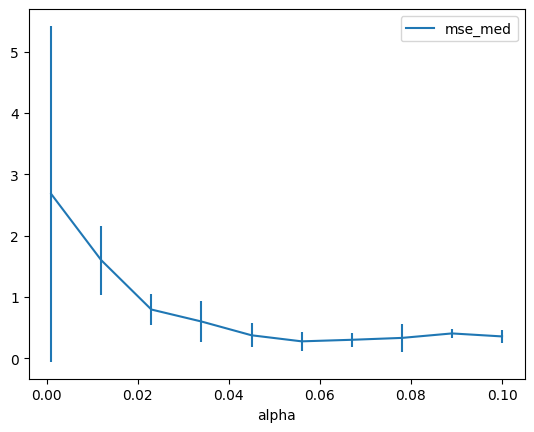

In [48]:
df.plot(y = "mse_med", x = "alpha", yerr = "mse_med_sd")

In [49]:
df.sort_values(by = "ocp_mean", ascending = False).head()

,avg,alpha,ocp_mean,ocp_stdev,mse_mean,mse_med,mse_stdev,ocp_mean_sd,mse_med_sd
5,True,0.056,0.828027,0.056742,0.275271,0.275271,0.0,0.002387,0.149948
4,True,0.045,0.826486,0.043560,0.374120,0.374120,0.0,0.005973,0.196853
7,True,0.078,0.822595,0.047208,0.331402,0.331402,0.0,0.009559,0.223940
6,True,0.067,0.820924,0.049467,0.300662,0.300662,0.0,0.005674,0.111141
8,True,0.089,0.817010,0.054253,0.404441,0.404441,0.0,0.008674,0.079787


We see not too much variance in terms of OC_P, so we can trust that 0.055 is a good value. MSE too is not varying too widely for this setting.

We find the best value at **alpha = 0.055**. We use **averaging, jitter, and an offset of 1.3**,